In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas
import scipy.interpolate as sci
import scipy.optimize as spo
from cycler import cycler
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from cmcrameri import cm
import matplotlib.colors as mcolors
import csv
from scipy.interpolate import LinearNDInterpolator
import glob
import re

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
#mpl.rcParams['lines.markersize'] = 30
#mpl.rcParams['lines.marker'] = 'o'
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
# mpl.rcParams['figure.labelsize'] = 20
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams["axes.xmargin"] = 0
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#1f449c', '#f05039', '#A8B6CC','#EEBAB4','#E57A77','#7CA1CC'])
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXGeneral'

## AlF

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
v_unit = 84e6*227.5e-9
m_unit = 227.5e-9/2/np.pi

In [4]:
# vx = v_unit*np.real(np.load("v.npy")[:,0])

In [8]:
name = "out_AlF_temp_6ms_2photon_3mm-4G_25-05-12.npz"
# name = "out_AlF_temp_3ms_2photon_12G_10mK_25-05-23"
datas = []
datas.append(np.load(name))
# datas.append(np.load(name + "_1.npz"))
# datas.append(np.load(name + "_2.npz"))
# datas.append(np.load(name + "_3.npz"))
# datas.append(np.load(name + "_4.npz"))
# datas.append(np.load(name + "_5.npz"))

# data = {"r" : np.concatenate([d['r'] for d in datas]),
#         "v" : np.concatenate([d['v'] for d in datas]),
#         "ts" : np.concatenate([d['ts'] for d in datas]),
#         "stats" : np.concatenate([d['stats'] for d in datas])}

data = {key : np.concatenate([d[key] for d in datas]) for key in datas[0].keys()}

r = np.real(data['r'])*m_unit
v = np.real(data['v'])*v_unit

# mask = np.logical_and(np.abs(r[:,0,-1])<0.006,np.logical_and(np.abs(r[:,1,-1])<0.006,np.abs(r[:,2,-1])<0.006))
# mask = np.logical_and(np.abs(v[:,0,-1])<5,np.logical_and(np.abs(v[:,1,-1])<5,np.abs(v[:,2,-1])<5))
mask = np.array([True]*r.shape[0])
r = r[mask]

vx = np.real(data['v'][mask,0])*v_unit
vy = np.real(data['v'][mask,1])*v_unit
vz = np.real(data['v'][mask,2])*v_unit
ts = np.array(data['ts'][mask])/(2*np.pi*84e6)
# ts = np.linspace(0.,1.,1000)
stats = data['stats']
N_atom = r.shape[0]
print(N_atom)

256


In [9]:
import lmfit
from scipy.stats import iqr
#print(2*np.std(v_final)**2*mass)
def normaldist(x, mu, sigma, dx):
    # Gaussian probability distribution function
    # probability of landing in a bin of width dx is p(x)dx
    return dx/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def lett_temperature(s, delta):
    """
    Returns the ratio of the expected temperature relative to the "bare" Doppler temperature.
    """
    return 0.5*(1+2*s+4*delta**2)/2/np.abs(delta)

def fit_vfinal(v_final, N_atom):
    dx = iqr(v_final)/N_atom**(1/3)
    if dx == 0:
        dx = 1
        xb = np.linspace(0.5,10.5,10)
        sigma0 = 1
    else:
        xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)
        sigma0 = np.std(v_final)
    xb = np.concatenate((-xb[::-1], xb))

    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(v_final, bins=xb)[0]/N_atom #Probability of an atom landing in this bin.'

    ok = (y>0)
    weights = np.zeros(ok.shape)
    weights[ok] = 1./np.sqrt(y[ok]/N_atom)
    model = lmfit.Model(normaldist)
    params = model.make_params()
    params['dx'].value = dx # bin width, probability of landing in the bin is p(x) dx
    params['dx'].vary = False
    params['mu'].value = 0.
    params['mu'].vary = False
    params['sigma'].value = sigma0

    result = model.fit(y[ok], params, x=x[ok], weights=weights[ok])

    return result, x, y, dx

In [10]:
vx[~np.isnan(vx)]

array([-0.24711398, -0.27520158, -0.52260529, ...,  0.28986392,
        0.36904563,  0.37207165])

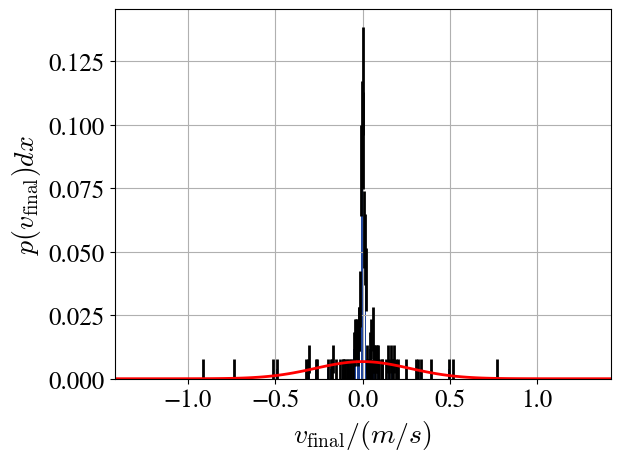

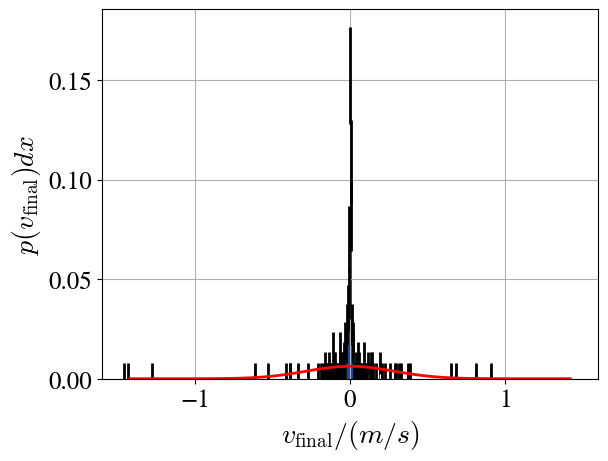

In [81]:
ressy = []
for i in range(1000):
    result, x, y, dx = fit_vfinal(vy[:,i], N_atom)
    ressy.append([result, x, y, dx])
    if i != 999:
        continue
    
    fig, ax = plt.subplots(1, 1)
    ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
    x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
    ax.plot(x_fit, result.eval(x=x_fit), 'r-')
    # ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

    ax.set_ylabel('$p(v_{\\rm final}) dx$')
    ax.set_xlabel('$v_{\\rm final}/(m/s)$');

ressz = []
for i in range(1000):
    result, x, y, dx = fit_vfinal(vz[:,i], N_atom)
    ressz.append([result, x, y, dx])
    if i != 999:
        continue
    
    fig, ax = plt.subplots(1, 1)
    ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
    x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
    ax.plot(x_fit, result.eval(x=x_fit), 'r-')
    # ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

    ax.set_ylabel('$p(v_{\\rm final}) dx$')
    ax.set_xlabel('$v_{\\rm final}/(m/s)$');

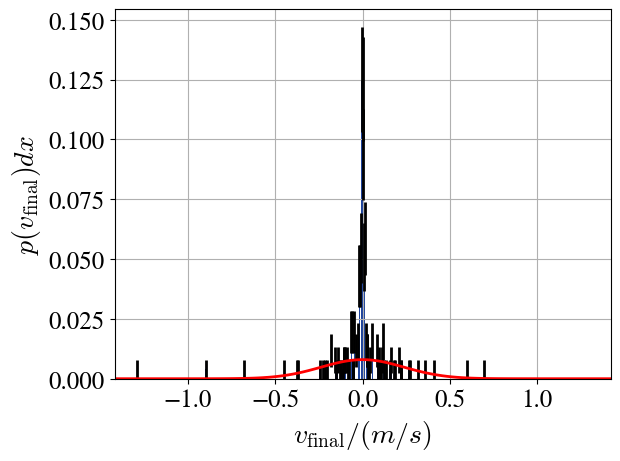

In [82]:
ress = []
for i in range(1000):
    result, x, y, dx = fit_vfinal(vx[:,i], N_atom)
    ress.append([result, x, y, dx])
    if i != 999:
        continue
    
    fig, ax = plt.subplots(1, 1)
    ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
    x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
    ax.plot(x_fit, result.eval(x=x_fit), 'r-')
    # ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

    ax.set_ylabel('$p(v_{\\rm final}) dx$')
    ax.set_xlabel('$v_{\\rm final}/(m/s)$');

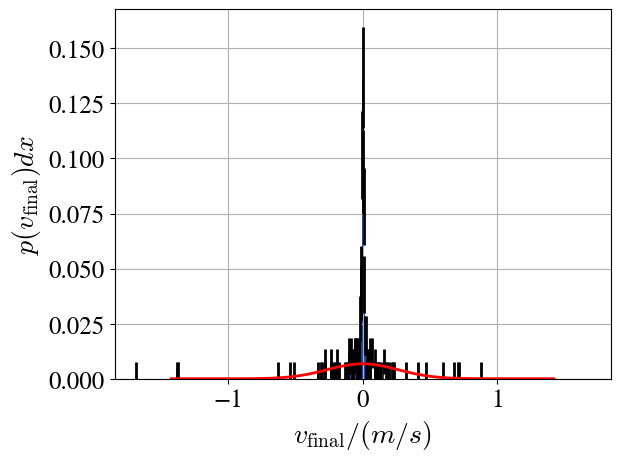

In [83]:
result, x, y, dx = ressz[-10]

fig, ax = plt.subplots(1, 1)
ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
ax.plot(x_fit, result.eval(x=x_fit), 'r-')
# ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

ax.set_ylabel('$p(v_{\\rm final}) dx$')
ax.set_xlabel('$v_{\\rm final}/(m/s)$');

In [84]:
result

In [85]:
print(result.params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23,"mK")

0.3823411878327406 mK


Text(0, 0.5, 'T [mK]')

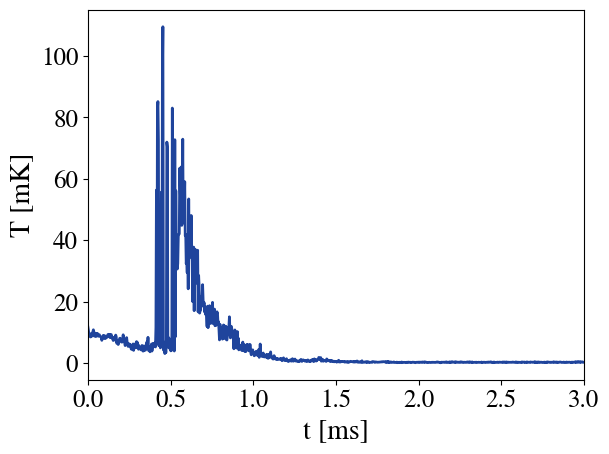

In [86]:
fig, ax = plt.subplots(1,1)
ax.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23 for res in ress])
ax.grid()
ax.set_xlabel("t [ms]")
ax.set_ylabel("T [mK]")
# ax.set_ylim([0,350])

Text(0, 0.5, 'T [mK]')

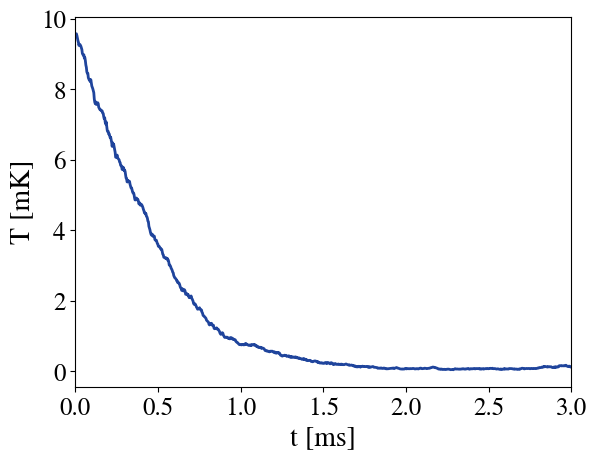

In [87]:
fig, ax = plt.subplots(1,1)
ax.plot(ts[0]*1e3,np.mean(vx**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
ax.grid()
ax.set_xlabel("t [ms]")
ax.set_ylabel("T [mK]")

Text(0, 0.5, 'T$_z$ [mK]')

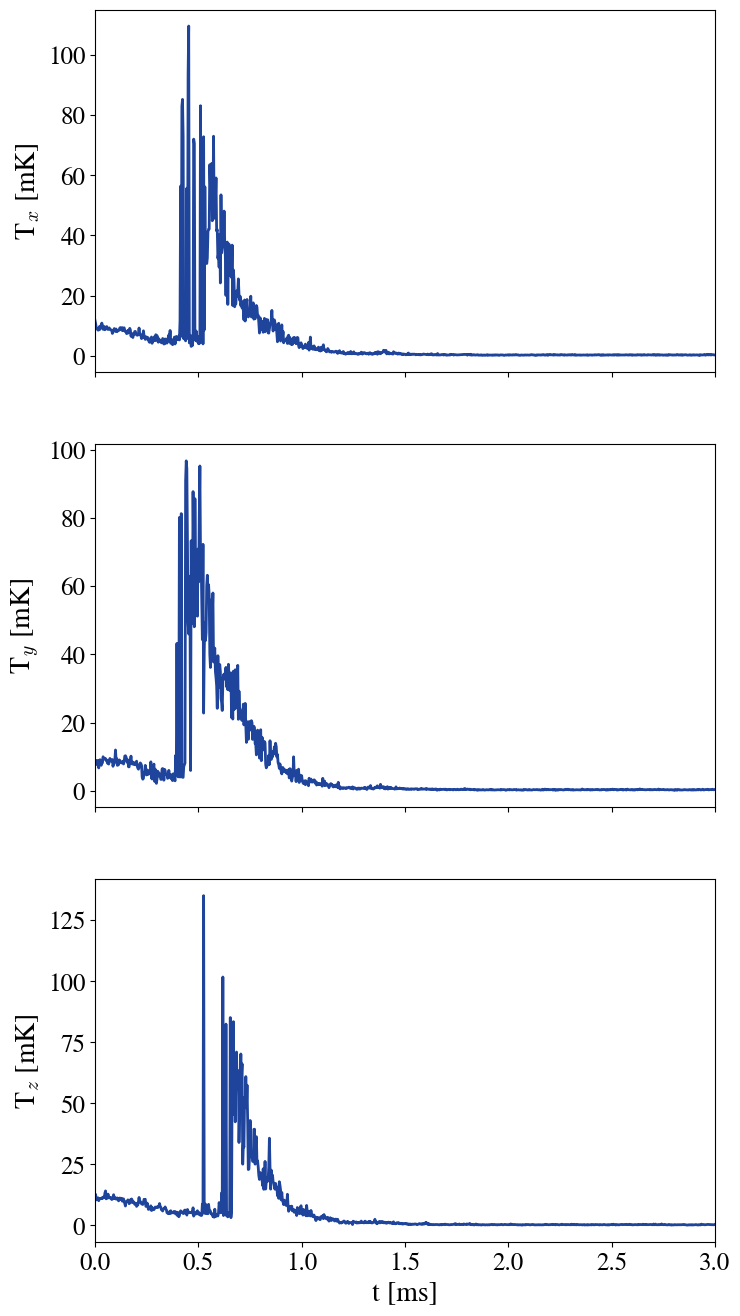

In [88]:
fig, (axx,axy,axz) = plt.subplots(3,1,sharex=True,figsize=[8,16])
axx.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23 for res in ress])
axx.grid()
# axx.set_xlabel("t [ms]")
axx.set_ylabel("T$_x$ [mK]")
# ax.set_ylim([0,350])
axy.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23 for res in ressy])
axy.grid()
# axx.set_xlabel("t [ms]")
axy.set_ylabel("T$_y$ [mK]")
# ax.set_ylim([0,350])
axz.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23 for res in ressz])
axz.grid()
axz.set_xlabel("t [ms]")
axz.set_ylabel("T$_z$ [mK]")
# ax.set_ylim([0,350])

Text(0, 0.5, 'T$_z$ [mK]')

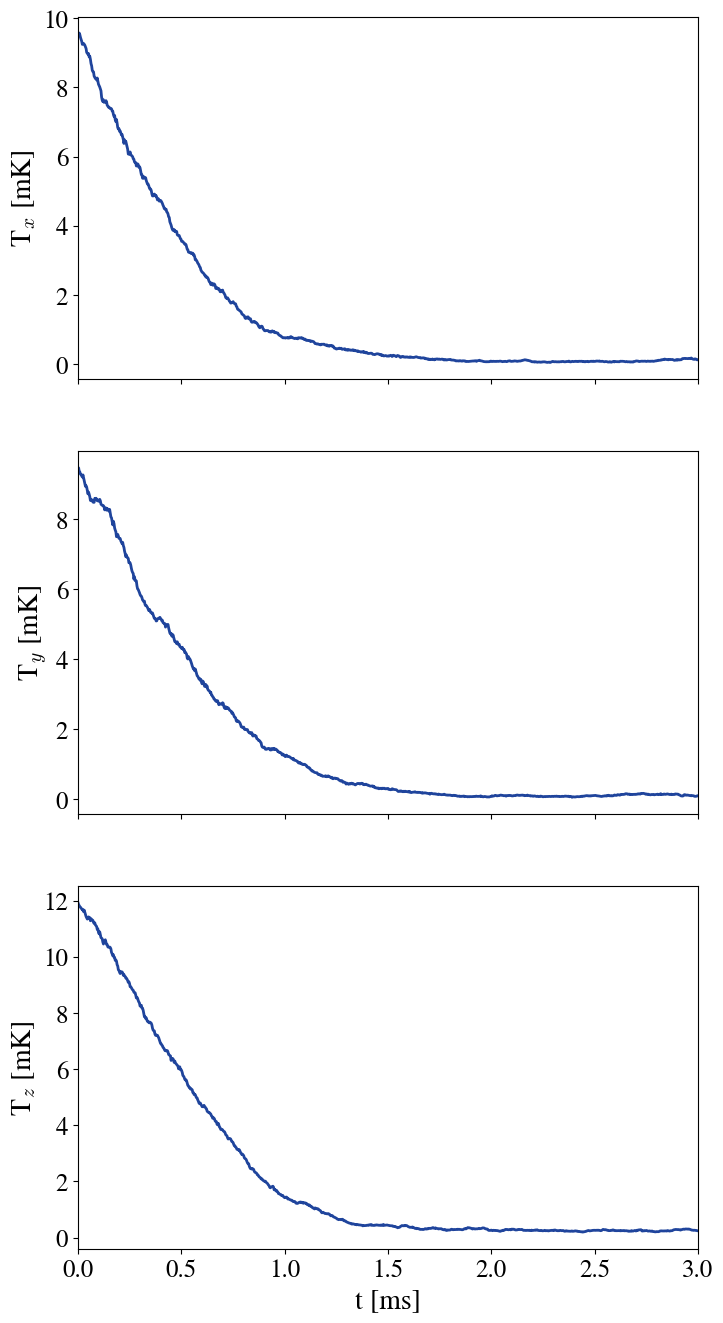

In [89]:
fig, (axx,axy,axz) = plt.subplots(3,1,sharex=True,figsize=[8,16])
axx.plot(ts[0]*1e3,np.mean(vx**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
axx.grid()
# axx.set_xlabel("t [ms]")
axx.set_ylabel("T$_x$ [mK]")
# axx.set_yscale('log')
# axx.set_ylim([0,0.2])
axy.plot(ts[0]*1e3,np.mean(vy**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
axy.grid()
# axx.set_xlabel("t [ms]")
axy.set_ylabel("T$_y$ [mK]")
# axy.set_yscale('log')
# axy.set_ylim([0,0.2])
axz.plot(ts[0]*1e3,np.mean(vz**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
axz.grid()
axz.set_xlabel("t [ms]")
axz.set_ylabel("T$_z$ [mK]")
# axz.set_yscale('log')
# axz.set_ylim([0,0.2])

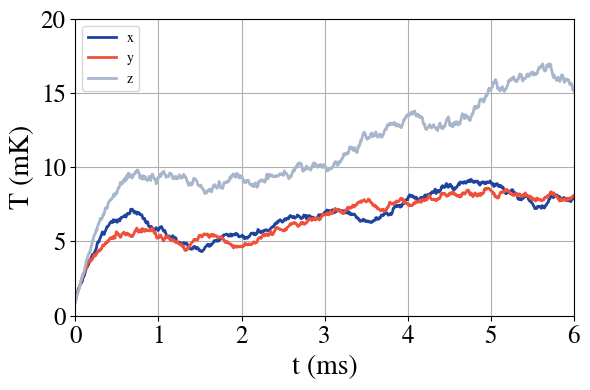

In [12]:
fig, ax = plt.subplots(1,1,sharex=True,figsize=[6,4], tight_layout=True)
ax.plot(ts[0]*1e3,np.mean(vx**2, axis=0)*46*1.66e-27*1e3/1.38e-23,label="x")
ax.plot(ts[0]*1e3,np.mean(vy**2, axis=0)*46*1.66e-27*1e3/1.38e-23,label="y")
ax.plot(ts[0]*1e3,np.mean(vz**2, axis=0)*46*1.66e-27*1e3/1.38e-23,label="z")
# ax.grid()
ax.set_xlabel("t (ms)")
ax.set_ylabel("T (mK)")
ax.legend()
# ax.set_yscale('log')
ax.set_ylim([0,20])
ylim = ax.get_ylim()
# fig.savefig("Figures/T_blue.pdf")
fig.savefig("Figures/T_red.pdf")

C:\Users\LP618\AppData\Local\Temp\ipykernel_15136\414674483.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0,20])
C:\Users\LP618\AppData\Local\Temp\ipykernel_15136\414674483.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0,20])
C:\Users\LP618\AppData\Local\Temp\ipykernel_15136\414674483.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0,20])


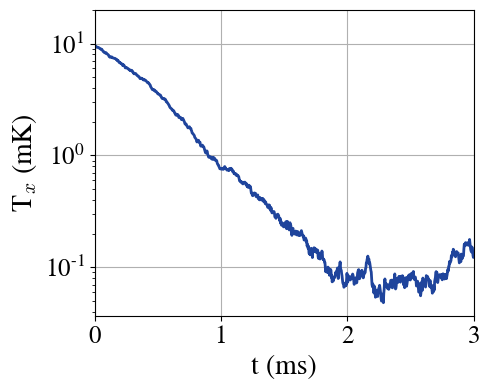

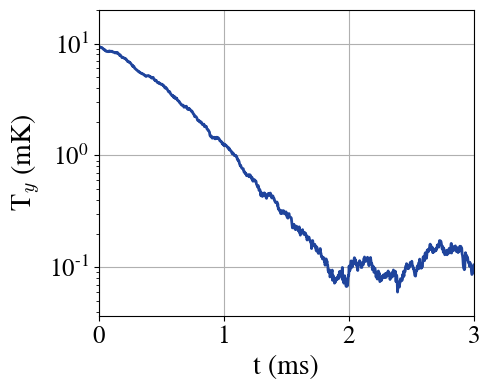

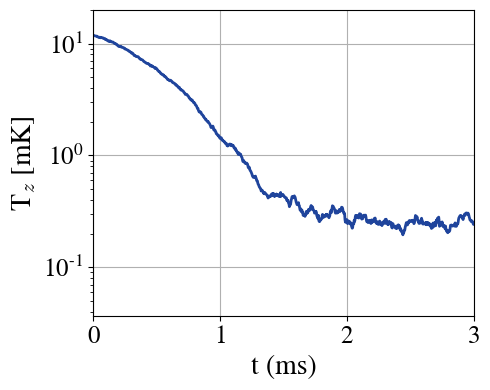

In [ ]:

fig, ax = plt.subplots(1,1,sharex=True,figsize=[5,4], tight_layout=True)
ax.plot(ts[0]*1e3,np.mean(vx**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
# ax.grid()
ax.set_xlabel("t (ms)")
ax.set_ylabel("T$_x$ (mK)")
ax.set_yscale('log')
ax.set_ylim([0,20])
ylim = ax.get_ylim()
# fig.savefig("Figures\\Tx_Blue.pdf")
fig, ax = plt.subplots(1,1,sharex=True,figsize=[5,4], tight_layout=True)
ax.plot(ts[0]*1e3,np.mean(vy**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
# ax.grid()
ax.set_xlabel("t (ms)")
ax.set_ylabel("T$_y$ (mK)")
ax.set_yscale('log')
ax.set_ylim([0,20])
ax.set_ylim(*ylim)
# fig.savefig("Figures\\Ty_Blue.pdf")
fig, ax = plt.subplots(1,1,sharex=True,figsize=[5,4], tight_layout=True)
ax.plot(ts[0]*1e3,np.mean(vz**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
# ax.grid()
ax.set_xlabel("t (ms)")
ax.set_ylabel("T$_z$ [mK]")
ax.set_yscale('log')
ax.set_ylim([0,20])
ax.set_ylim(*ylim)
# fig.savefig("Figures\\Tz_Blue.pdf")

Text(0, 0.5, 'v [m/s]')

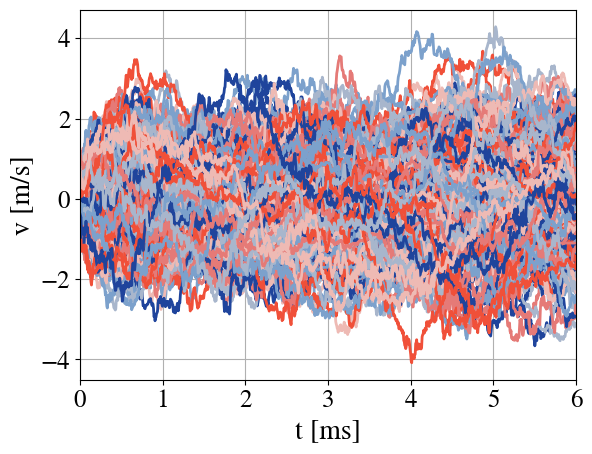

In [49]:
[plt.plot(ts[0]*1e3, v) for v in vx[:N_atom]]
plt.xlabel("t [ms]")
plt.ylabel("v [m/s]")

Text(0, 0.5, 'v [m/s]')

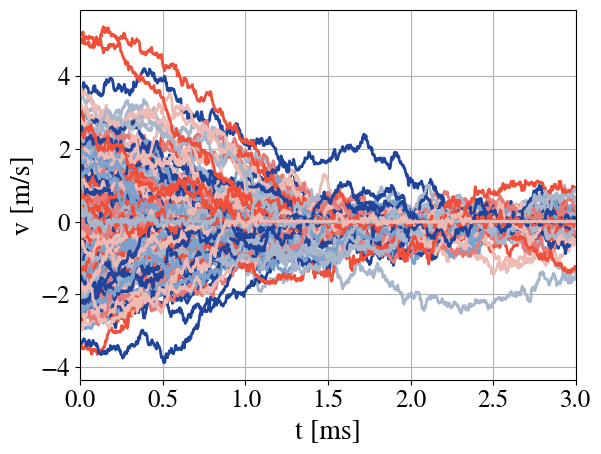

In [40]:
plt.figure()
[plt.plot(ts[0]*1e3, v) for v in vz[:N_atom]]
plt.xlabel("t [ms]")
plt.ylabel("v [m/s]")

In [41]:
# d = np.load("out_AlF_temp.npz")
# data = {}
# data['v'] = d['v']
# data['stats'] = d['stats']
# data['ts'] = d['ts']
# data['r'] = np.load('r.npy')

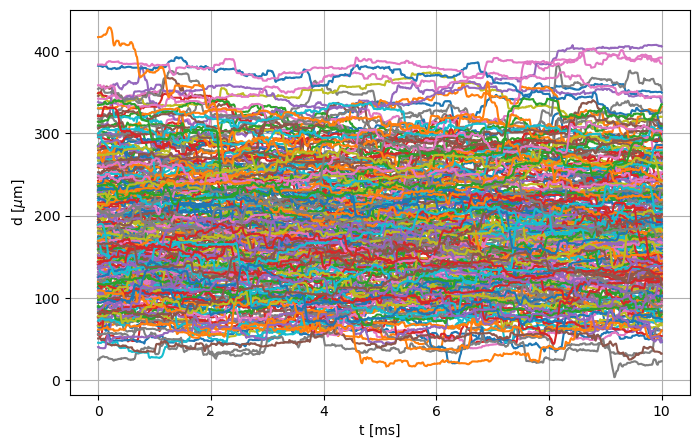

In [46]:
fig, ax = plt.subplots(1,1,figsize=[8,5])
[ax.plot(ts[i]*1000,np.sqrt(r[i,0]**2 + r[i,1]**2 + r[i,2]**2)*1e6) for i in range(N_atom)]
ax.set_ylabel("d [$\\mu$m]")
ax.set_xlabel("t [ms]")
# ax.set_ylim([0,10000])
ax.grid()

Text(0, 0.5, '$\\mu$ [$\\mu$m]')

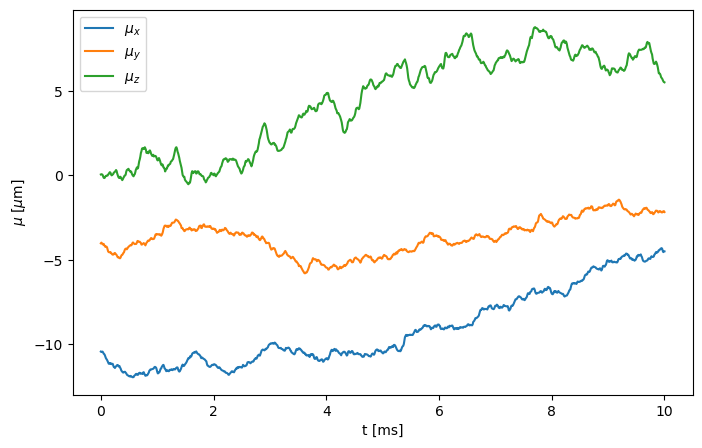

In [47]:
fig, ax = plt.subplots(1,1,figsize=[8,5])
ax.plot(ts[0]*1e3, np.mean(r[:,0]*1e6, axis=0), label="$\\mu_x$")
ax.plot(ts[0]*1e3, np.mean(r[:,1]*1e6, axis=0), label="$\\mu_y$")
ax.plot(ts[0]*1e3, np.mean(r[:,2]*1e6, axis=0), label="$\\mu_z$")

ax.legend()
ax.set_xlabel("t [ms]")
ax.set_ylabel("$\\mu$ [$\\mu$m]")

(array([ 57., 115.,  98.,  86., 168., 185., 185.,  54.,  36.,  16.]),
 array([-6.68441826e+08, -4.69685269e+08, -2.70928713e+08, -7.21721562e+07,
         1.26584400e+08,  3.25340957e+08,  5.24097513e+08,  7.22854070e+08,
         9.21610626e+08,  1.12036718e+09,  1.31912374e+09]),
 <BarContainer object of 10 artists>)

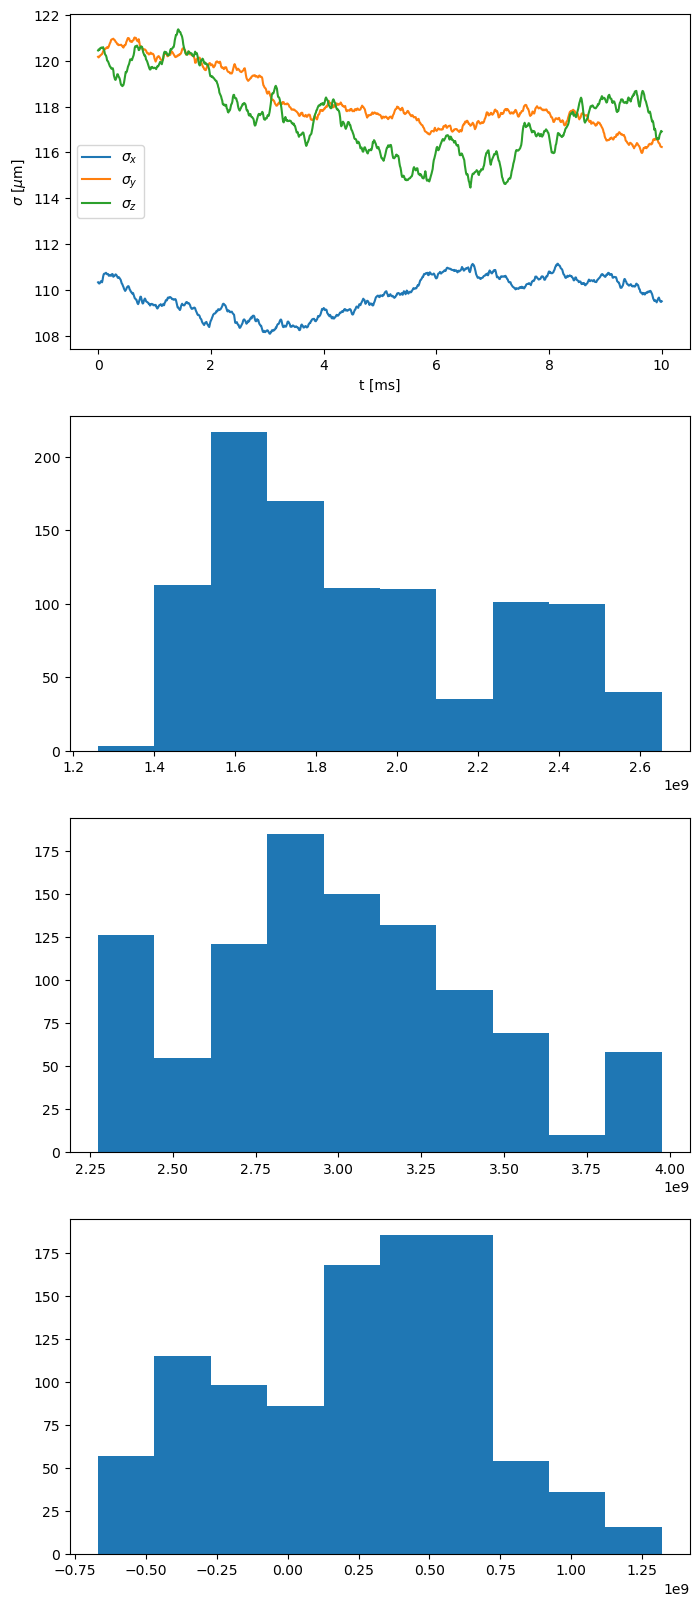

In [48]:
fig, (ax, axx, axy, axz) = plt.subplots(4,1,figsize=[8,20])
ax.plot(ts[0]*1e3, np.std(r[:,0]*1e6, axis=0), label="$\\sigma_x$")
ax.plot(ts[0]*1e3, np.std(r[:,1]*1e6, axis=0), label="$\\sigma_y$")
ax.plot(ts[0]*1e3, np.std(r[:,2]*1e6, axis=0), label="$\\sigma_z$")
ax.legend()
ax.set_xlabel("t [ms]")
ax.set_ylabel("$\\sigma$ [$\\mu$m]")

axx.hist(data['r'][-1,0]*1e6)
axy.hist(data['r'][-1,1]*1e6)
axz.hist(data['r'][-1,2]*1e6)

# ax.set_xlim(0,0.2)
# ax.set_ylim(800,1500)

Text(0.5, 0, 'd [$\\mu$m]')

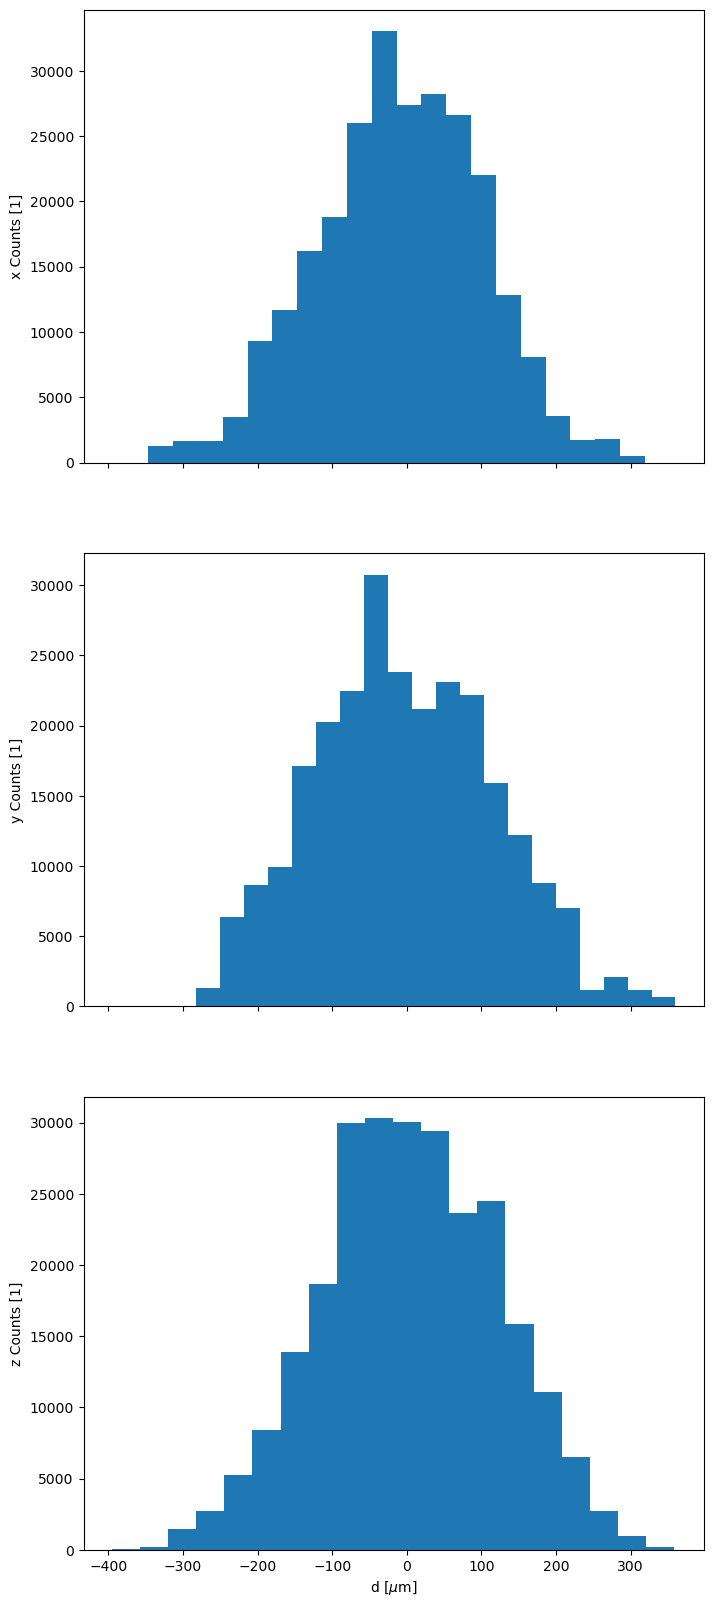

In [49]:
fig, (axx, axy, axz) = plt.subplots(3,1,figsize=[8,20], sharex=True)

axx.hist(r[:,0].reshape((N_atom*1000,))*1e6,bins=20)
axx.set_ylabel("x Counts [1]")
axy.hist(r[:,1].reshape((N_atom*1000,))*1e6,bins=20)
axy.set_ylabel("y Counts [1]")
axz.hist(r[:,2].reshape((N_atom*1000,))*1e6,bins=20)
axz.set_ylabel("z Counts [1]")
axz.set_xlabel("d [$\\mu$m]")

In [50]:
# %matplotlib

In [51]:
import numpy.linalg as lin
import cmcrameri.cm as scicmap
import matplotlib.colors as mcolors

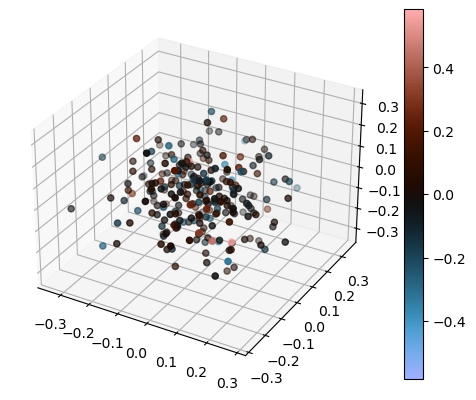

In [52]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

vl = np.real(data['v'][mask]*v_unit)[:,:,-1]
rs = np.array([lin.norm(np.real(r)[:,:,-1],axis=1)]*3).T
rl = np.real(r)[:,:,-1]/rs

vt = np.einsum("ij,ij->i",rl,vl)

a = ax.scatter(np.real(r)[:,0,-1]*1000,np.real(r)[:,1,-1]*1000,np.real(r)[:,2,-1]*1000, c = vt, cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
plt.colorbar(a)
# plt.xlim(-1,1)
# plt.ylim(-1,1)

(-4.5, 4.5)

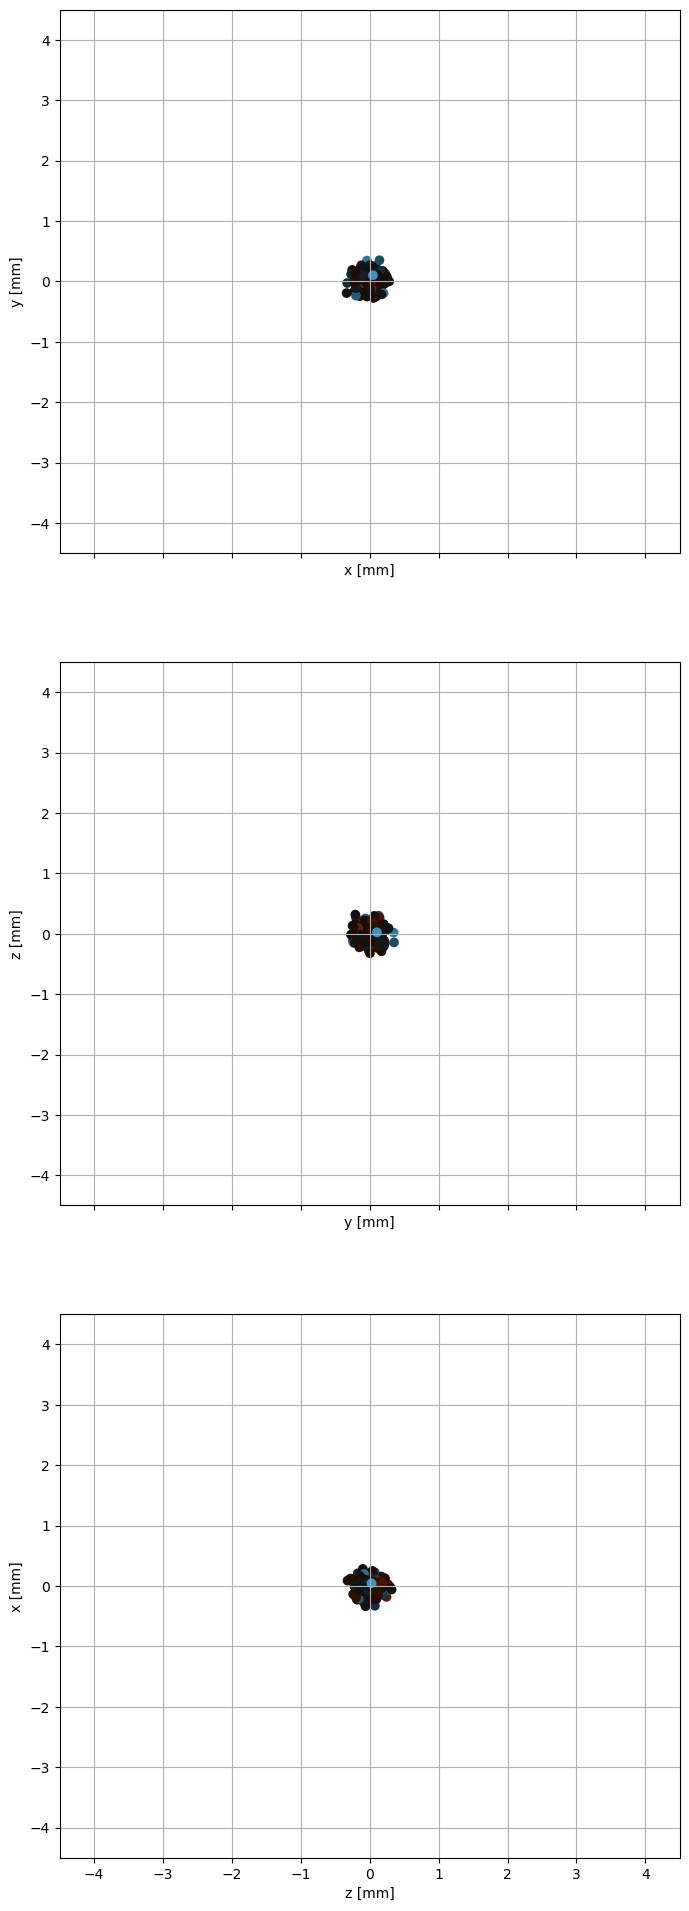

In [53]:
fig, (axxy, axyz, axzx) = plt.subplots(3,1,sharex=True,sharey=True,figsize=[8,24])

vl = np.real(data['v'][mask]*v_unit)[:,:,-1]
rs = np.array([lin.norm(np.real(r)[:,:,-1],axis=1)]*3).T
rl = np.real(r)[:,:,-1]/rs

vt = np.einsum("ij,ij->i",rl,vl)

axxy.scatter(np.real(r)[:,0,-1]*1000,np.real(r)[:,1,-1]*1000, c = vt, cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
axxy.set_xlabel("x [mm]")
axxy.set_ylabel("y [mm]")
axxy.grid()

axyz.scatter(np.real(r)[:,1,-1]*1000,np.real(r)[:,2,-1]*1000, c = vt, cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
axyz.set_xlabel("y [mm]")
axyz.set_ylabel("z [mm]")
axyz.grid()

axzx.scatter(np.real(r)[:,2,-1]*1000,np.real(r)[:,0,-1]*1000, c = vt, cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
axzx.set_xlabel("z [mm]")
axzx.set_ylabel("x [mm]")
axzx.grid()

axxy.set_xlim(-4.5,4.5)
axxy.set_ylim(-4.5,4.5)

# plt.xlim(-1,1)
# plt.ylim(-1,1)

In [13]:
lostN = np.sum((np.abs(v[:,:,10:]-v[:,:,:-10]) < 1e-3).all(axis=1),axis = 0)

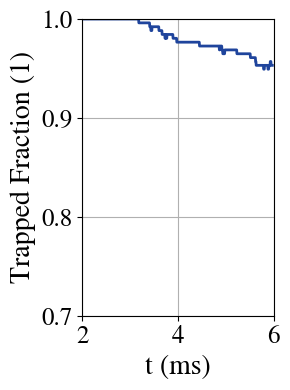

In [14]:
fig, ax = plt.subplots(1,1,sharex=True,figsize=[3,4], tight_layout=True)
ax.plot(1e3*ts[0,5:-5], (N_atom-lostN)/N_atom)
ax.set_xlim(2,6)
ax.set_ylim(0.70,1)
# plt.grid()
ax.set_ylabel("Trapped Fraction (1)")
ax.set_xlabel("t (ms)")
fig.savefig("Figures\\Trapped_fraction_1000Gpercm.pdf")

In [38]:
%matplotlib

Using matplotlib backend: <object object at 0x000002BFCFB51540>


In [54]:
import matplotlib.animation as animation
import matplotlib as mpl

fig, (axxy, axyz, axzx) = plt.subplots(3,1,sharex=True,sharey=True,figsize=[8,24])

# cbar = fig.add_subfigure()

vl = np.real(data['v']*v_unit)[:,:,-1]
rs = np.array([lin.norm(np.real(data['r'])[:,:,-1],axis=1)]*3).T
rl = np.real(data['r'])[:,:,-1]/rs

vt = np.einsum("ij,ij->i",rl,vl)

vla = np.real(data['v']*v_unit)[:,:,:]
rsa = lin.norm(np.real(data['r'])[:,:,:],axis=1)
rsa[np.isclose(rsa,0)] = 1
# rl = np.real(data['r'])[:,:,:]/rs

vta = np.einsum("ik,ijk,ijk->ik",1/rsa,vla,np.real(data['r'])[:,:,:])

norm = mcolors.CenteredNorm(0,5)

# bg = fig.canvas.copy_from_bbox(fig.bbox)

xy = axxy.scatter(np.real(data['r'])[:,0,-1]*1000*m_unit,np.real(data['r'])[:,1,-1]*1000*m_unit, cmap=scicmap.berlin,norm=norm, marker = 'o')
axxy.set_xlabel("x [mm]")
axxy.set_ylabel("y [mm]")
axxy.grid()

yz = axyz.scatter(np.real(data['r'])[:,1,-1]*1000*m_unit,np.real(data['r'])[:,2,-1]*1000*m_unit, cmap=scicmap.berlin,norm=norm, marker = 'o')
axyz.set_xlabel("y [mm]")
axyz.set_ylabel("z [mm]")
axyz.grid()

zx = axzx.scatter(np.real(data['r'])[:,2,-1]*1000*m_unit,np.real(data['r'])[:,0,-1]*1000*m_unit, cmap=scicmap.berlin,norm=norm, marker = 'o')
axzx.set_xlabel("z [mm]")
axzx.set_ylabel("x [mm]")
axzx.grid()

axxy.set_xlim(-4.5,4.5)
axxy.set_ylim(-4.5,4.5)

axxy.set_aspect("equal")
axyz.set_aspect("equal")
axzx.set_aspect("equal")

# xy.set_animated(True)
# yz.set_animated(True)
# zx.set_animated(True)

fig.suptitle("6 ms")

axc = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=scicmap.berlin), ax=fig.get_axes())
axc.set_label("$v_t$ [m/s]")
xy.set_cmap(scicmap.berlin)
yz.set_cmap(scicmap.berlin)
zx.set_cmap(scicmap.berlin)

xy.set_norm(norm)
yz.set_norm(norm)
zx.set_norm(norm)

def update(frame):
    
    # fig.canvas.restore_region(bg)
    # x = np.real(data['r'])[:,0,frame]*1000*m_unit
    # y = np.real(data['r'])[:,1,frame]*1000*m_unit
    # z = np.real(data['r'])[:,2,frame]*1000*m_unit
    
    vt = vta[:,frame]
    
    # xy.set_offsets(np.stack([x,y]).T)
    # yz.set_offsets(np.stack([y,z]).T)
    # zx.set_offsets(np.stack([z,x]).T)
    
    xy.set_offsets(np.real(data['r'])[:,(0,1),frame]*1000*m_unit)
    yz.set_offsets(np.real(data['r'])[:,(1,2),frame]*1000*m_unit)
    zx.set_offsets(np.real(data['r'])[:,(2,0),frame]*1000*m_unit)
    
    
    rgba = xy.to_rgba(vt)
    fig.suptitle(f"{ts[0,frame]*1000:.3} ms")
    
    
    xy.set_color(rgba)
    yz.set_color(rgba)
    zx.set_color(rgba)
    
    # xy.set_color([0,0,0,0])
    
    # xy.set_facecolors(vt)
    # yz.set_color(vt)
    # zx.set_color(vt)
    
    # xy.draw()
    # yz.draw()
    # zx.draw()
    
    # axxy.draw_artist(xy)
    # axyz.draw_artist(yz)
    # axzx.draw_artist(zx)
    # fig.canvas.blit(fig.bbox)
    # fig.canvas.flush_events()
    
    return (xy,yz,zx)

ani = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=1)

writer = animation.PillowWriter(fps=100,
                                metadata=dict(artist='Me'),
                                bitrate=18000)
ani.save('Dynamics_temp_blue_25-05-25.gif', writer=writer)

# plt.xlim(-1,1)
# plt.ylim(-1,1)

In [80]:
plt.plot(vta[1])

In [68]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

vl = np.real(data['v']*v_unit)[:,:,::50]
rs = lin.norm(np.real(data['r'])[:,:,::50],axis=1)
# rl = np.real(data['r'])[:,:,:]/rs

vt = np.einsum("ik,ijk,ijk->ik",1/rs,vl,np.real(data['r'])[:,:,::50])

imax = 100

norm = mcolors.CenteredNorm(0,halfrange=8)
[ax.scatter(np.real(data['r'])[i,0,::50]*1000*m_unit,np.real(data['r'])[i,1,::50]*1000*m_unit,np.real(data['r'])[i,2,::50]*1000*m_unit, c = vt[i], cmap=scicmap.berlin,norm=norm) for i in range(imax)]
a = ax.scatter(np.real(data['r'])[imax,0,::50]*1000*m_unit,np.real(data['r'])[imax,1,::50]*1000*m_unit,np.real(data['r'])[imax,2,::50]*1000*m_unit, c = vt[imax], cmap=scicmap.berlin,norm=norm)

plt.colorbar(a)
# plt.xlim(-1,1)
# plt.ylim(-1,1)

## CaF

In [188]:
import numpy as np
import matplotlib.pyplot as plt

In [189]:
v_unit = 8.3e6*606e-9
m_unit = 606e-9/2/np.pi

In [190]:
# vx = v_unit*np.real(np.load("v.npy")[:,0])

In [191]:
data = np.load("out_CaF_temp_Harvard_sp_0mK_500um_s2_25-06-02.npz")
r = np.real(data['r'])*m_unit
v = np.real(data['v'])*v_unit

# mask = np.logical_and(np.abs(r[:,0,-1])<0.006,np.logical_and(np.abs(r[:,1,-1])<0.006,np.abs(r[:,2,-1])<0.006))
mask = np.logical_and(np.abs(v[:,0,-1])<0.2,np.logical_and(np.abs(v[:,1,-1])<0.2,np.abs(v[:,2,-1])<0.2))
# mask = np.array([True]*r.shape[0])
r = r[mask]

vx = np.real(data['v'][mask,0])*v_unit
vy = np.real(data['v'][mask,1])*v_unit
vz = np.real(data['v'][mask,2])*v_unit
ts = np.array(data['ts'][mask])/(2*np.pi*8.3e6)
# ts = np.linspace(0.,1.,1000)
stats = data['stats']
N_atom = r.shape[0]
print(N_atom)

255


In [192]:
r[:,0]

array([[ 7.74163815e-04,  7.82885831e-04,  7.89210392e-04, ...,
         7.78666960e-05,  7.76558197e-05,  7.68334455e-05],
       [ 1.27751255e-04,  1.37754929e-04,  1.46725691e-04, ...,
         5.69501888e-05,  5.89164091e-05,  5.97767731e-05],
       [ 5.41602834e-04,  5.26192878e-04,  5.11009730e-04, ...,
         5.43691935e-05,  5.42285836e-05,  5.42780436e-05],
       ...,
       [ 4.62782214e-04,  4.71556632e-04,  4.77722027e-04, ...,
         2.43480290e-04,  2.43294292e-04,  2.40917181e-04],
       [ 4.33059186e-04,  4.34969585e-04,  4.35809122e-04, ...,
         3.31123861e-04,  3.30956245e-04,  3.31445140e-04],
       [-1.23116425e-03, -1.23399025e-03, -1.23677603e-03, ...,
        -1.00361136e-03, -1.00371080e-03, -1.00438013e-03]])

In [193]:
import lmfit
from scipy.stats import iqr
#print(2*np.std(v_final)**2*mass)
def normaldist(x, mu, sigma, dx):
    # Gaussian probability distribution function
    # probability of landing in a bin of width dx is p(x)dx
    return dx/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def lett_temperature(s, delta):
    """
    Returns the ratio of the expected temperature relative to the "bare" Doppler temperature.
    """
    return 0.5*(1+2*s+4*delta**2)/2/np.abs(delta)

def fit_vfinal(v_final, N_atom):
    dx = iqr(v_final)/N_atom**(1/3)
    if dx == 0:
        dx = 1
        xb = np.linspace(0.5,10.5,10)
        sigma0 = 1
    else:
        xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)
        sigma0 = np.std(v_final)
    xb = np.concatenate((-xb[::-1], xb))

    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(v_final, bins=xb)[0]/N_atom #Probability of an atom landing in this bin.'

    ok = (y>0)
    weights = np.zeros(ok.shape)
    weights[ok] = 1./np.sqrt(y[ok]/N_atom)
    model = lmfit.Model(normaldist)
    params = model.make_params()
    params['dx'].value = dx # bin width, probability of landing in the bin is p(x) dx
    params['dx'].vary = False
    params['mu'].value = 0.
    params['mu'].vary = False
    params['sigma'].value = sigma0

    result = model.fit(y[ok], params, x=x[ok], weights=weights[ok])

    return result, x, y, dx

In [194]:
vx[~np.isnan(vx)]

array([ 0.43451876,  0.37999071,  0.29165824, ...,  0.04912565,
        0.00263511, -0.09464666])

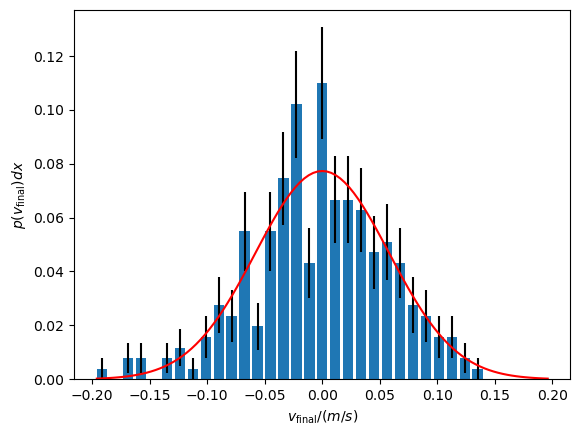

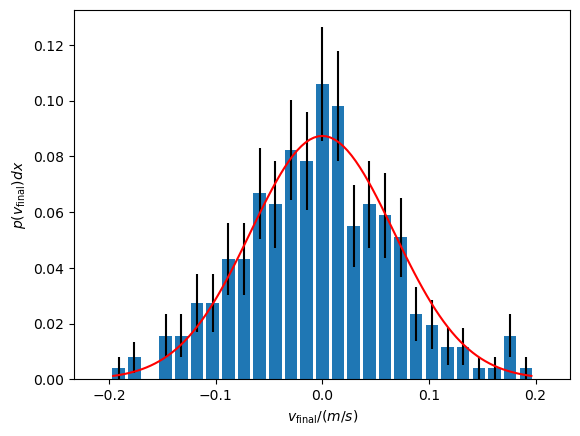

In [195]:
ressy = []
for i in range(1000):
    result, x, y, dx = fit_vfinal(vy[:,i], N_atom)
    ressy.append([result, x, y, dx])
    if i != 999:
        continue
    
    fig, ax = plt.subplots(1, 1)
    ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
    x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
    ax.plot(x_fit, result.eval(x=x_fit), 'r-')
    # ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

    ax.set_ylabel('$p(v_{\\rm final}) dx$')
    ax.set_xlabel('$v_{\\rm final}/(m/s)$');

ressz = []
for i in range(1000):
    result, x, y, dx = fit_vfinal(vz[:,i], N_atom)
    ressz.append([result, x, y, dx])
    if i != 999:
        continue
    
    fig, ax = plt.subplots(1, 1)
    ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
    x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
    ax.plot(x_fit, result.eval(x=x_fit), 'r-')
    # ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

    ax.set_ylabel('$p(v_{\\rm final}) dx$')
    ax.set_xlabel('$v_{\\rm final}/(m/s)$');

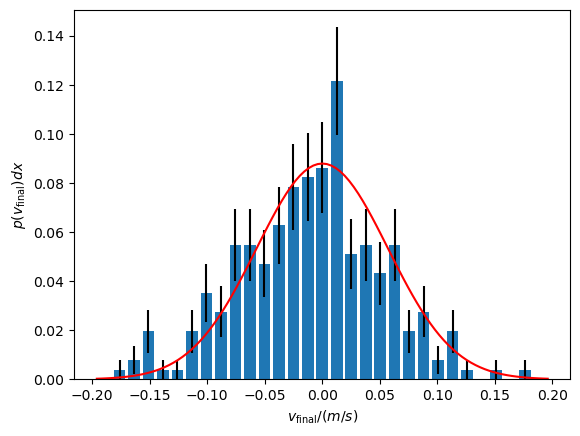

In [196]:
ress = []
for i in range(1000):
    result, x, y, dx = fit_vfinal(vx[:,i], N_atom)
    ress.append([result, x, y, dx])
    if i != 999:
        continue
    
    fig, ax = plt.subplots(1, 1)
    ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
    x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
    ax.plot(x_fit, result.eval(x=x_fit), 'r-')
    # ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

    ax.set_ylabel('$p(v_{\\rm final}) dx$')
    ax.set_xlabel('$v_{\\rm final}/(m/s)$');

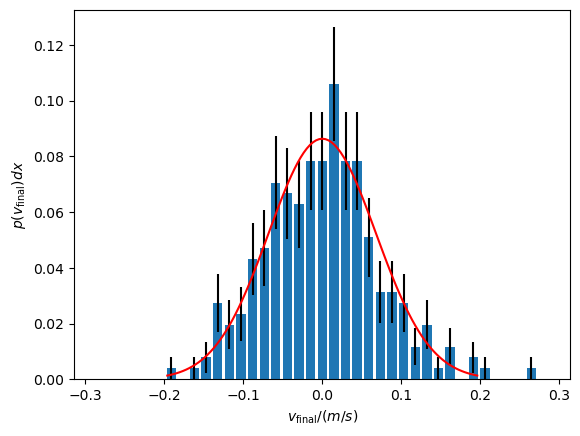

In [197]:
result, x, y, dx = ressz[-100]

fig, ax = plt.subplots(1, 1)
ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
ax.plot(x_fit, result.eval(x=x_fit), 'r-')
# ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

ax.set_ylabel('$p(v_{\\rm final}) dx$')
ax.set_xlabel('$v_{\\rm final}/(m/s)$');

In [198]:
result

In [199]:
print(result.params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23,"mK")

0.025550619390578573 mK


Text(0, 0.5, 'T [mK]')

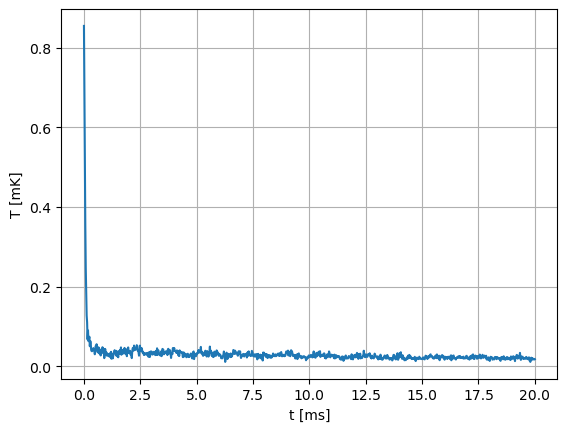

In [200]:
fig, ax = plt.subplots(1,1)
ax.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23 for res in ress])
ax.grid()
ax.set_xlabel("t [ms]")
ax.set_ylabel("T [mK]")
# ax.set_ylim([0,350])

Text(0, 0.5, 'T [mK]')

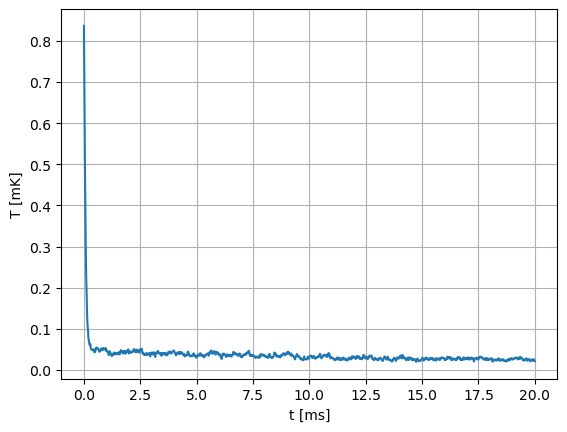

In [201]:
fig, ax = plt.subplots(1,1)
ax.plot(ts[0]*1e3,np.mean(vx**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
ax.grid()
ax.set_xlabel("t [ms]")
ax.set_ylabel("T [mK]")

Text(0, 0.5, 'T$_z$ [mK]')

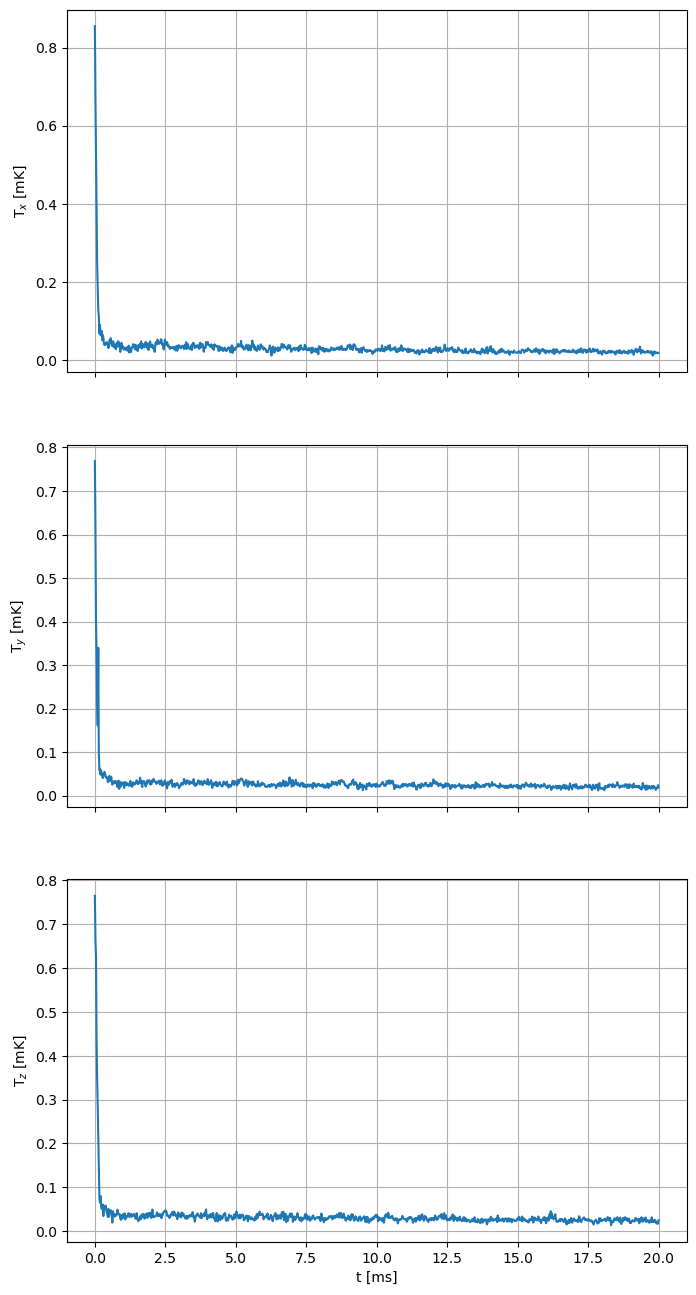

In [202]:
fig, (axx,axy,axz) = plt.subplots(3,1,sharex=True,figsize=[8,16])
axx.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23 for res in ress])
axx.grid()
# axx.set_xlabel("t [ms]")
axx.set_ylabel("T$_x$ [mK]")
# ax.set_ylim([0,350])
axy.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23 for res in ressy])
axy.grid()
# axx.set_xlabel("t [ms]")
axy.set_ylabel("T$_y$ [mK]")
# ax.set_ylim([0,350])
axz.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*46*1.66e-27*1e3/1.38e-23 for res in ressz])
axz.grid()
axz.set_xlabel("t [ms]")
axz.set_ylabel("T$_z$ [mK]")
# ax.set_ylim([0,350])

Text(0, 0.5, 'T$_z$ [mK]')

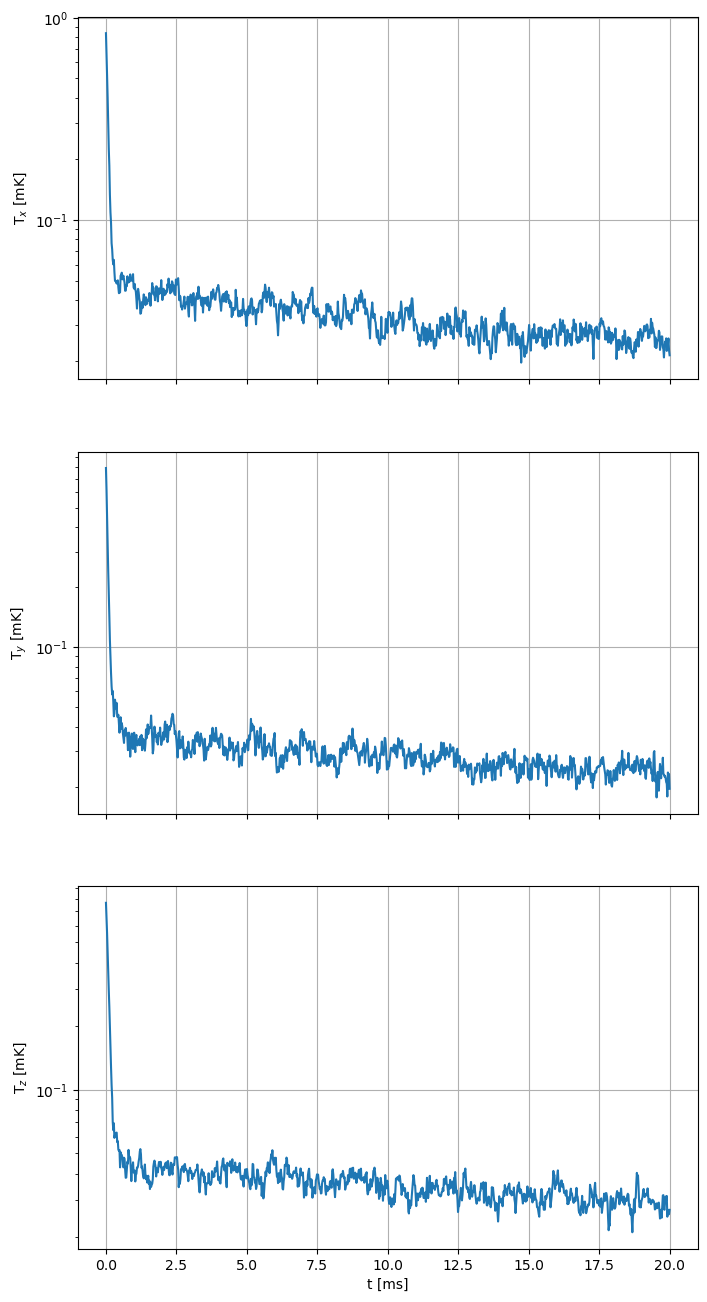

In [203]:
fig, (axx,axy,axz) = plt.subplots(3,1,sharex=True,figsize=[8,16])
axx.plot(ts[0]*1e3,np.mean(vx**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
axx.grid()
axx.set_yscale('log')
# axx.set_xlabel("t [ms]")
axx.set_ylabel("T$_x$ [mK]")
# ax.set_ylim([0,350])
axy.plot(ts[0]*1e3,np.mean(vy**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
axy.grid()
axy.set_yscale('log')
# axx.set_xlabel("t [ms]")
axy.set_ylabel("T$_y$ [mK]")
# ax.set_ylim([0,350])
axz.plot(ts[0]*1e3,np.mean(vz**2, axis=0)*46*1.66e-27*1e3/1.38e-23)
axz.grid()
axz.set_yscale('log')
axz.set_xlabel("t [ms]")
axz.set_ylabel("T$_z$ [mK]")
# ax.set_ylim([0,350])

Text(0, 0.5, 'v [m/s]')

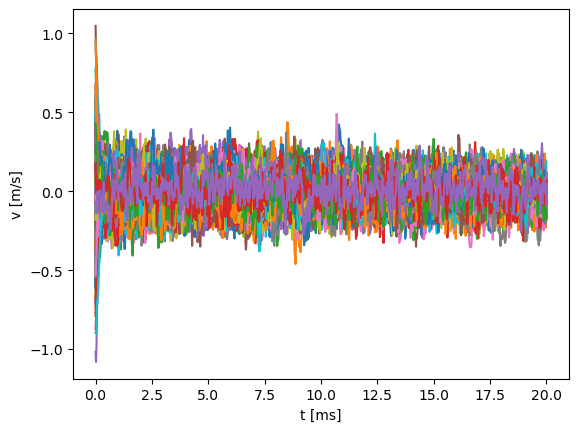

In [204]:
[plt.plot(ts[0]*1e3, v) for v in vx[:N_atom]]
plt.xlabel("t [ms]")
plt.ylabel("v [m/s]")

Text(0, 0.5, 'v [m/s]')

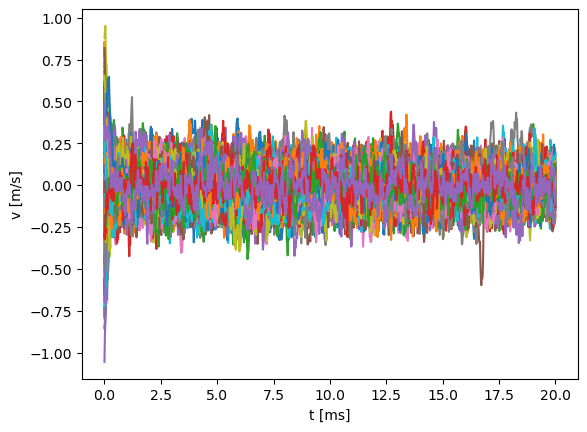

In [205]:
plt.figure()
[plt.plot(ts[0]*1e3, v) for v in vz[:N_atom]]
plt.xlabel("t [ms]")
plt.ylabel("v [m/s]")

In [206]:
# d = np.load("out_AlF_temp.npz")
# data = {}
# data['v'] = d['v']
# data['stats'] = d['stats']
# data['ts'] = d['ts']
# data['r'] = np.load('r.npy')

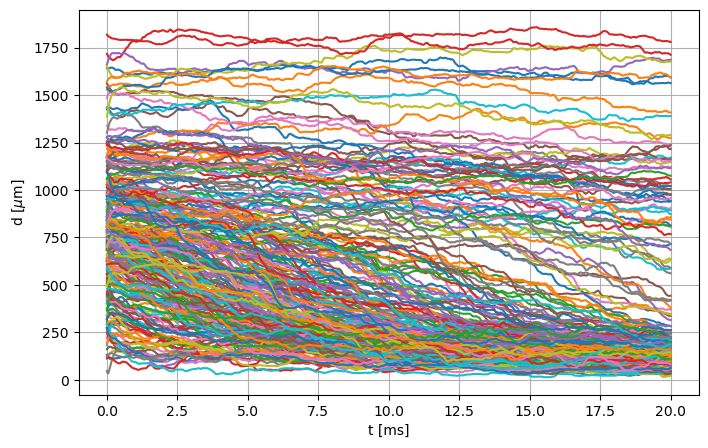

In [207]:
fig, ax = plt.subplots(1,1,figsize=[8,5])
[ax.plot(ts[i]*1000,np.sqrt(r[i,0]**2 + r[i,1]**2 + r[i,2]**2)*1e6) for i in range(N_atom)]
ax.set_ylabel("d [$\\mu$m]")
ax.set_xlabel("t [ms]")
# ax.set_ylim([0,1000])
ax.grid()

Text(0, 0.5, '$\\mu$ [$\\mu$m]')

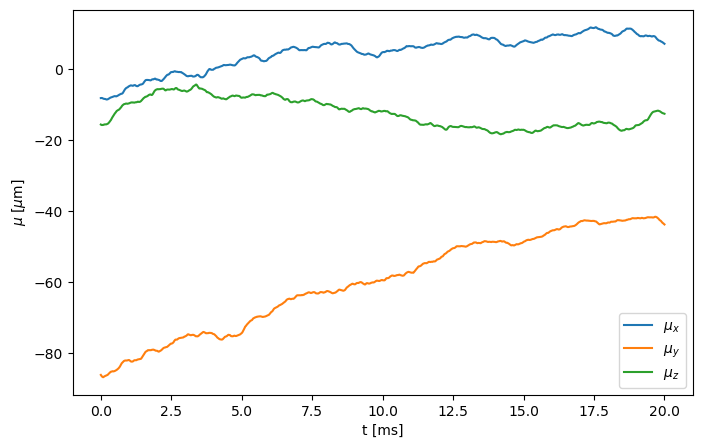

In [208]:
fig, ax = plt.subplots(1,1,figsize=[8,5])
ax.plot(ts[0]*1e3, np.mean(r[:,0]*1e6, axis=0), label="$\\mu_x$")
ax.plot(ts[0]*1e3, np.mean(r[:,1]*1e6, axis=0), label="$\\mu_y$")
ax.plot(ts[0]*1e3, np.mean(r[:,2]*1e6, axis=0), label="$\\mu_z$")

ax.legend()
ax.set_xlabel("t [ms]")
ax.set_ylabel("$\\mu$ [$\\mu$m]")

(array([ 60.,  74., 106., 189.,  99.,  26., 128., 157.,  54., 107.]),
 array([-5.13018903e+09, -4.88054809e+09, -4.63090715e+09, -4.38126621e+09,
        -4.13162527e+09, -3.88198433e+09, -3.63234339e+09, -3.38270245e+09,
        -3.13306151e+09, -2.88342057e+09, -2.63377963e+09]),
 <BarContainer object of 10 artists>)

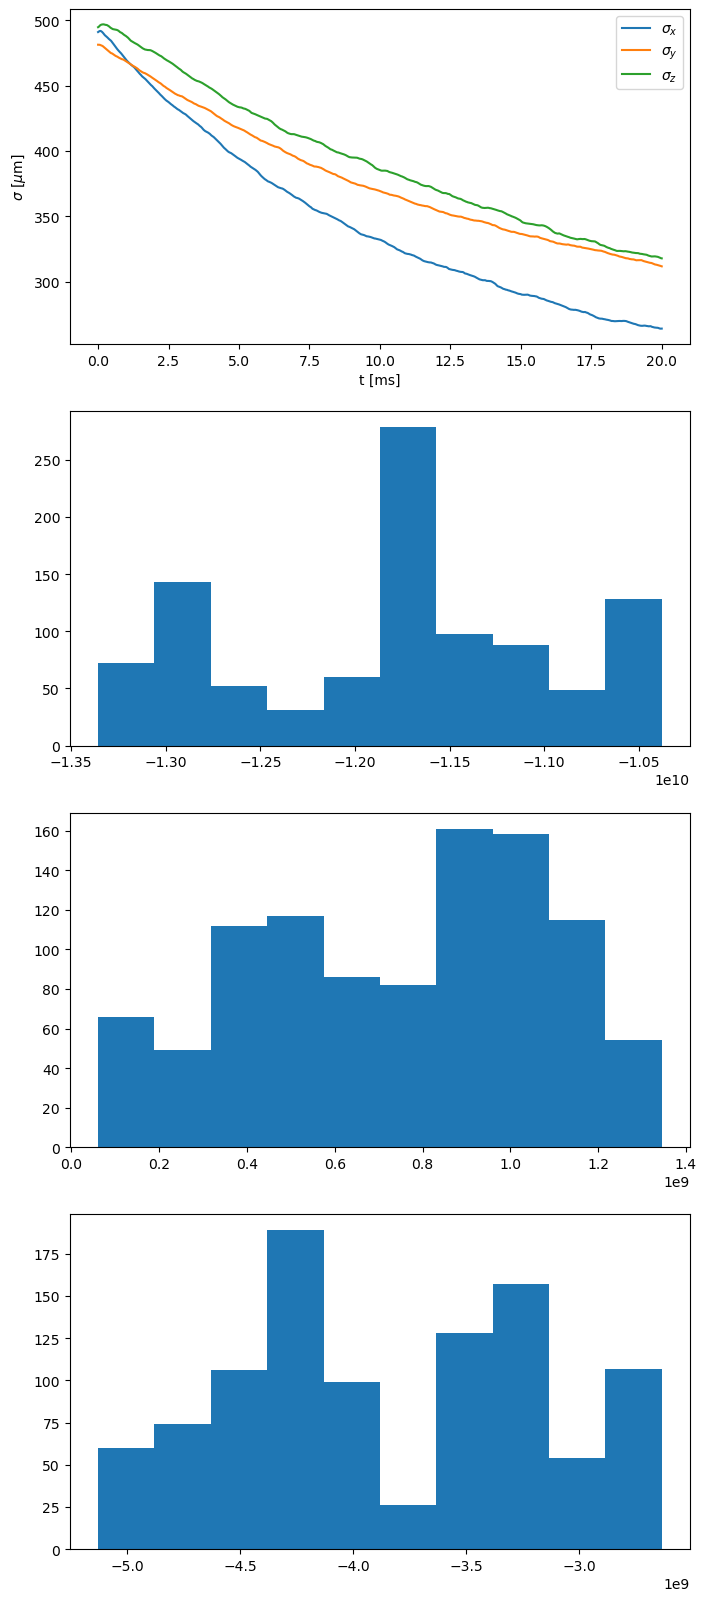

In [209]:
fig, (ax, axx, axy, axz) = plt.subplots(4,1,figsize=[8,20])
ax.plot(ts[0]*1e3, np.std(r[:,0]*1e6, axis=0), label="$\\sigma_x$")
ax.plot(ts[0]*1e3, np.std(r[:,1]*1e6, axis=0), label="$\\sigma_y$")
ax.plot(ts[0]*1e3, np.std(r[:,2]*1e6, axis=0), label="$\\sigma_z$")
ax.legend()
ax.set_xlabel("t [ms]")
ax.set_ylabel("$\\sigma$ [$\\mu$m]")

axx.hist(data['r'][-1,0]*1e6)
axy.hist(data['r'][-1,1]*1e6)
axz.hist(data['r'][-1,2]*1e6)

# ax.set_xlim(0,0.2)
# ax.set_ylim(800,1500)

Text(0.5, 0, 'd [$\\mu$m]')

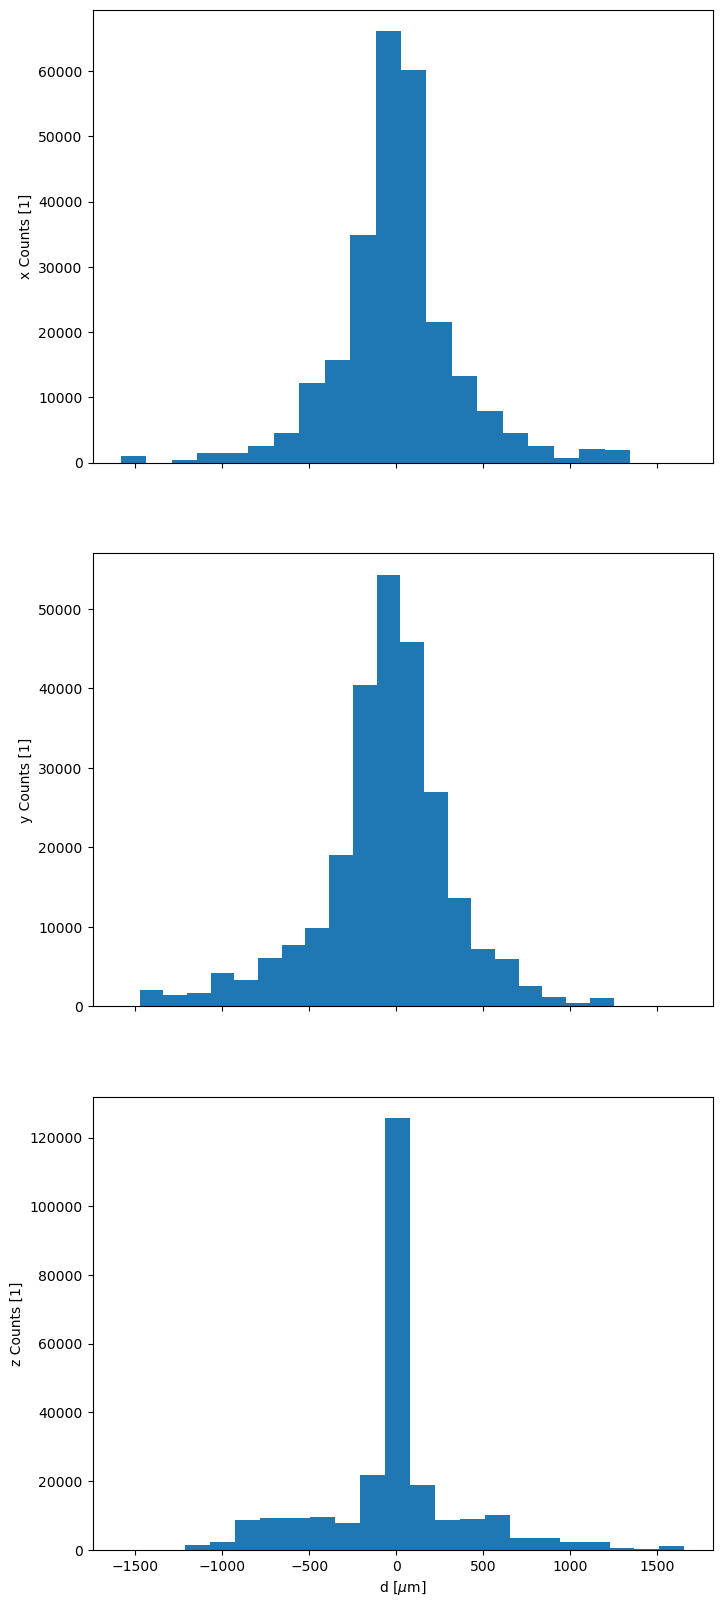

In [210]:
fig, (axx, axy, axz) = plt.subplots(3,1,figsize=[8,20], sharex=True)

axx.hist(r[:,0].reshape((N_atom*1000,))*1e6,bins=20)
axx.set_ylabel("x Counts [1]")
axy.hist(r[:,1].reshape((N_atom*1000,))*1e6,bins=20)
axy.set_ylabel("y Counts [1]")
axz.hist(r[:,2].reshape((N_atom*1000,))*1e6,bins=20)
axz.set_ylabel("z Counts [1]")
axz.set_xlabel("d [$\\mu$m]")

In [211]:
# %matplotlib

In [212]:
import numpy.linalg as lin
import cmcrameri.cm as scicmap
import matplotlib.colors as mcolors

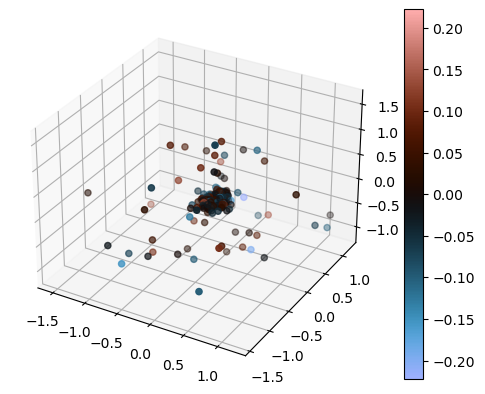

In [213]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

vl = np.real(data['v'][mask]*v_unit)[:,:,-1]
rs = np.array([lin.norm(np.real(r)[:,:,-1],axis=1)]*3).T
rl = np.real(r)[:,:,-1]/rs

vt = np.einsum("ij,ij->i",rl,vl)

a = ax.scatter(np.real(r)[:,0,-1]*1000,np.real(r)[:,1,-1]*1000,np.real(r)[:,2,-1]*1000, c = vt, cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
plt.colorbar(a)
# plt.xlim(-1,1)
# plt.ylim(-1,1)

(-4.5, 4.5)

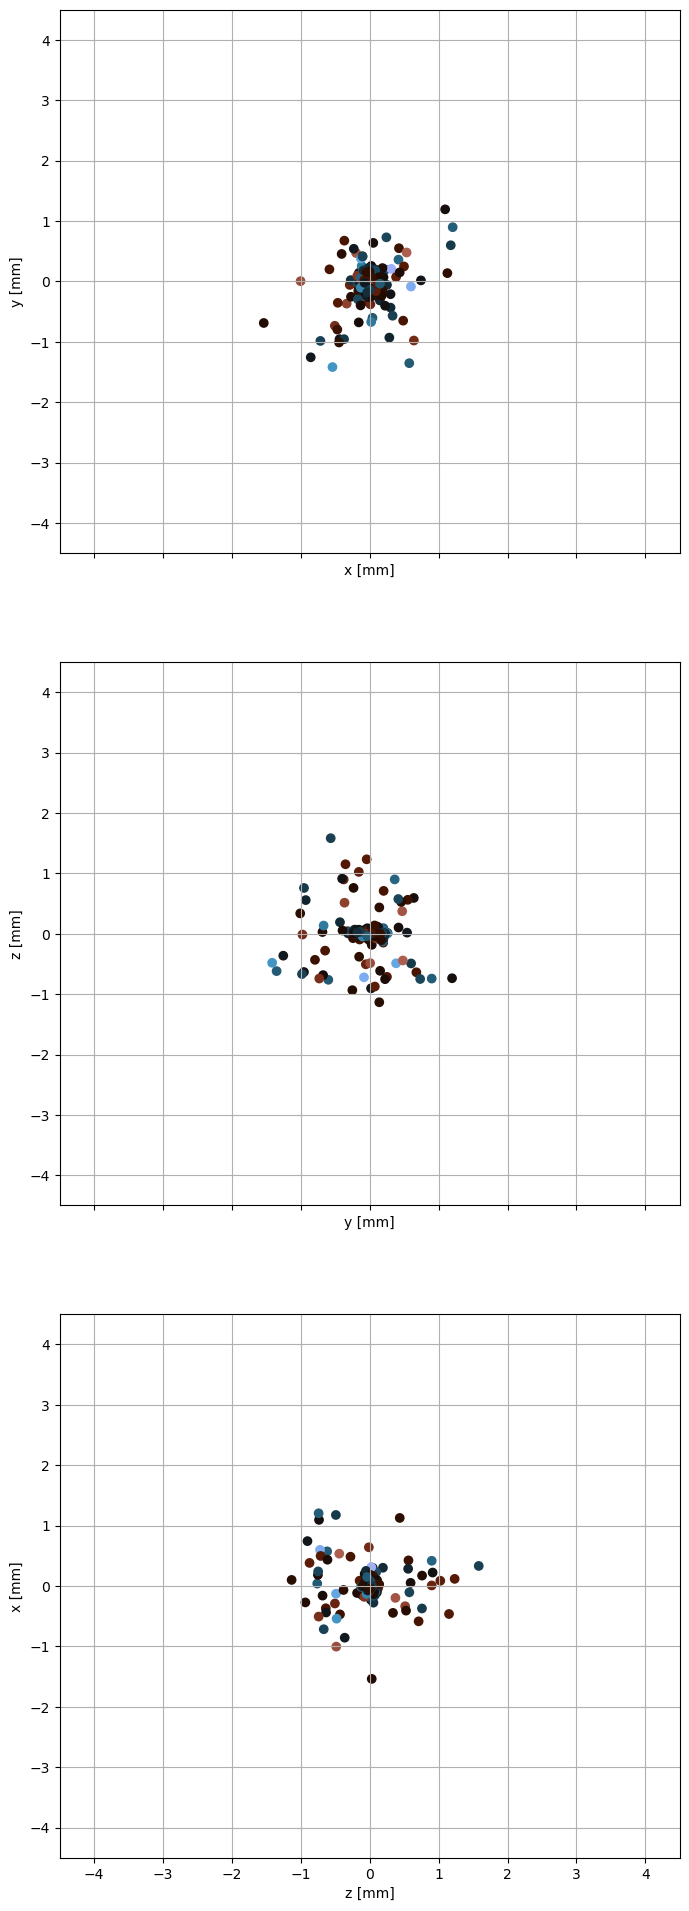

In [214]:
fig, (axxy, axyz, axzx) = plt.subplots(3,1,sharex=True,sharey=True,figsize=[8,24])

vl = np.real(data['v'][mask]*v_unit)[:,:,-1]
rs = np.array([lin.norm(np.real(r)[:,:,-1],axis=1)]*3).T
rl = np.real(r)[:,:,-1]/rs

vt = np.einsum("ij,ij->i",rl,vl)

axxy.scatter(np.real(r)[:,0,-1]*1000,np.real(r)[:,1,-1]*1000, c = vt, cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
axxy.set_xlabel("x [mm]")
axxy.set_ylabel("y [mm]")
axxy.grid()

axyz.scatter(np.real(r)[:,1,-1]*1000,np.real(r)[:,2,-1]*1000, c = vt, cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
axyz.set_xlabel("y [mm]")
axyz.set_ylabel("z [mm]")
axyz.grid()

axzx.scatter(np.real(r)[:,2,-1]*1000,np.real(r)[:,0,-1]*1000, c = vt, cmap=scicmap.berlin,norm=mcolors.CenteredNorm(0))
axzx.set_xlabel("z [mm]")
axzx.set_ylabel("x [mm]")
axzx.grid()

axxy.set_xlim(-4.5,4.5)
axxy.set_ylim(-4.5,4.5)

# plt.xlim(-1,1)
# plt.ylim(-1,1)

## Rb

In [101]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
v_unit = 5.75e6*794.97851156e-9
mm_unit = 1000*794.97851156e-9/2/np.pi

In [3]:
data = np.load("out_Rb_temp-10.npz")
vx = data['v'][:,0]*v_unit
ts = data['ts']/(2*np.pi*5.75e6)
stats = data['stats']

In [4]:
data.files

['v', 'r', 'ts', 'stats']

In [5]:
N_atom = 256

In [6]:
import lmfit
from scipy.stats import iqr
#print(2*np.std(v_final)**2*mass)
def normaldist(x, mu, sigma, dx):
    # Gaussian probability distribution function
    # probability of landing in a bin of width dx is p(x)dx
    return dx/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def lett_temperature(s, delta):
    """
    Returns the ratio of the expected temperature relative to the "bare" Doppler temperature.
    """
    return 0.5*(1+2*s+4*delta**2)/2/np.abs(delta)

def fit_vfinal(v_final, N_atom):
    dx = 2*iqr(v_final)/N_atom**(1/3)
    xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)
    xb = np.concatenate((-xb[::-1], xb))

    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(v_final, bins=xb)[0]/N_atom #Probability of an atom landing in this bin.'

    ok = (y>0)
    weights = np.zeros(ok.shape)
    weights[ok] = 1./np.sqrt(y[ok]/N_atom)
    model = lmfit.Model(normaldist)
    params = model.make_params()
    params['dx'].value = dx # bin width, probability of landing in the bin is p(x) dx
    params['dx'].vary = False
    params['mu'].value = 0.
    params['mu'].vary = False
    params['sigma'].value = np.std(v_final)

    result = model.fit(y[ok], params, x=x[ok], weights=weights[ok])

    return result, x, y, dx

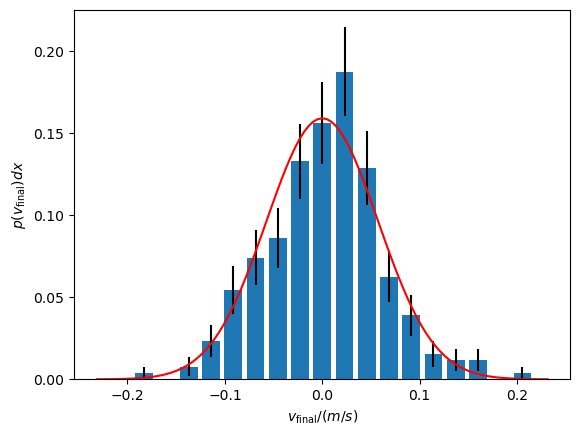

In [7]:
ress = []
for i in range(1000):
    result, x, y, dx = fit_vfinal(vx[:,i], N_atom)
    ress.append([result, x, y, dx])
    if i != 999:
        continue
    
    fig, ax = plt.subplots(1, 1)
    ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
    x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
    ax.plot(x_fit, result.eval(x=x_fit), 'r-')
    # ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

    ax.set_ylabel('$p(v_{\\rm final}) dx$')
    ax.set_xlabel('$v_{\\rm final}/(m/s)$');

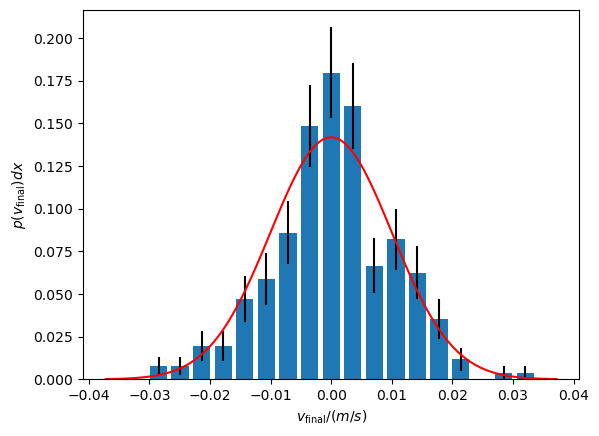

In [8]:
i = 0
result, x, y, dx = ress[i]

fig, ax = plt.subplots(1, 1)
ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error
x_fit = np.linspace(-1.1*np.amax(np.abs(vx[:,i])), 1.1*np.amax(np.abs(vx[:,i])), 101)
ax.plot(x_fit, result.eval(x=x_fit), 'r-')
# ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

ax.set_ylabel('$p(v_{\\rm final}) dx$')
ax.set_xlabel('$v_{\\rm final}/(m/s)$');

In [9]:
result

In [10]:
print(result.params["sigma"].value**2*87*1.66e-27*1e3/1.38e-23,"mK")

0.0010497312312933956 mK


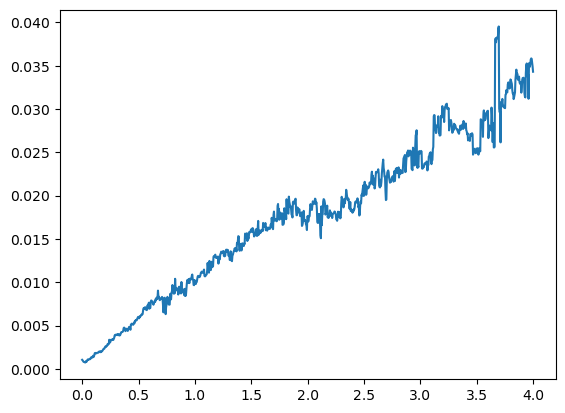

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(ts[0]*1e3,[res[0].params["sigma"].value**2*87*1.66e-27*1e3/1.38e-23 for res in ress])


In [12]:
np.std(vx, axis=0).shape

(1000,)

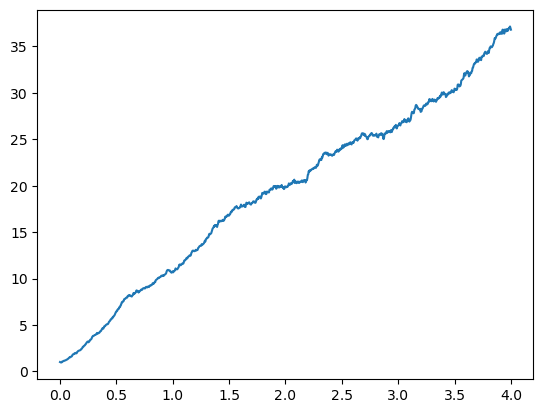

In [13]:
fig, ax = plt.subplots(1,1)
ax.plot(ts[0]*1e3,np.mean(vx**2, axis=0)*87*1.66e-27*1e6/1.38e-23)

In [14]:
N_atom

256

In [15]:
def get_temp(file):
    data = np.load(file)
    vx = data['v'][:,0]*v_unit
    ts = data['ts']/(2*np.pi*5.75e6)
    stats = data['stats']
    
    ress = []
    for i in range(1000):
        result, x, y, dx = fit_vfinal(vx[:,i], N_atom)
        ress.append([result, x, y, dx])


    return (ts, [res[0].params["sigma"].value**2*87*1.66e-27*1e3/1.38e-23 for res in ress], np.mean(vx**2, axis=0)*87*1.66e-27*1e3/1.38e-23)

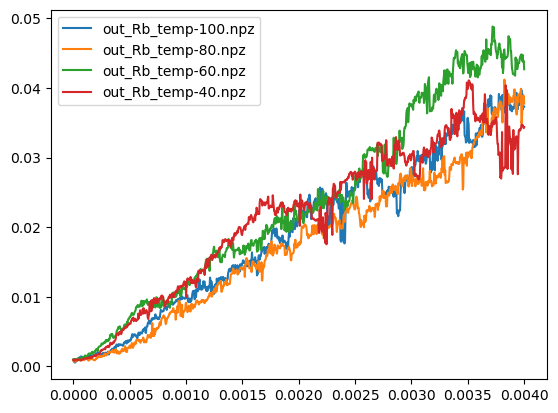

In [16]:
[plt.plot(t[0], temps, label=i) for i,(t, temps, mean_temps) in [(i,get_temp(i)) for i in ("out_Rb_temp-100.npz", "out_Rb_temp-80.npz", 'out_Rb_temp-60.npz', 'out_Rb_temp-40.npz')]]
plt.legend()

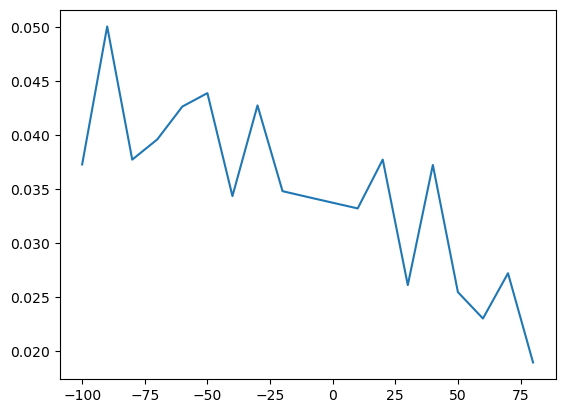

In [17]:
dets = [-100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20, -10,   10,   20,   30,   40,   50,   60,   70,   80]
temps = [get_temp(f"out_Rb_temp{det}.npz")[1][-1] for det in dets]
plt.plot(dets, temps)

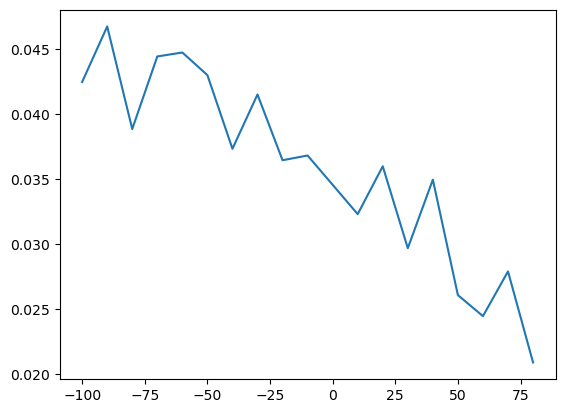

In [18]:
dets = [-100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20, -10,   10,   20,   30,   40,   50,   60,   70,   80]
temps = [get_temp(f"out_Rb_temp{det}.npz")[2][-1] for det in dets]
plt.plot(dets, temps)

(array([ 1.,  1.,  1.,  2.,  0.,  1.,  4.,  2.,  0.,  2.,  4.,  4.,  0.,
         6.,  8.,  6.,  0.,  9., 11.,  9.,  0., 11., 10., 22.,  0., 11.,
        20., 12., 11.,  0., 16., 13., 10.,  0.,  8.,  7.,  7.,  0.,  3.,
         6.,  6.,  0.,  3.,  3.,  1.,  0.,  2.,  1.,  0.,  2.]),
 array([28.  , 28.76, 29.52, 30.28, 31.04, 31.8 , 32.56, 33.32, 34.08,
        34.84, 35.6 , 36.36, 37.12, 37.88, 38.64, 39.4 , 40.16, 40.92,
        41.68, 42.44, 43.2 , 43.96, 44.72, 45.48, 46.24, 47.  , 47.76,
        48.52, 49.28, 50.04, 50.8 , 51.56, 52.32, 53.08, 53.84, 54.6 ,
        55.36, 56.12, 56.88, 57.64, 58.4 , 59.16, 59.92, 60.68, 61.44,
        62.2 , 62.96, 63.72, 64.48, 65.24, 66.  ]),
 <BarContainer object of 50 artists>)

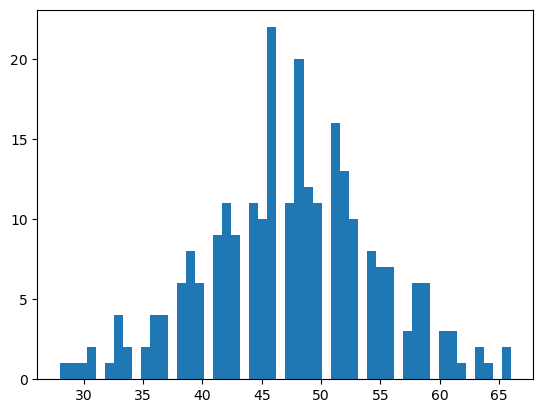

In [19]:
plt.hist(stats[:,1],bins=50)

[[<matplotlib.lines.Line2D at 0x12288af37c0>]]

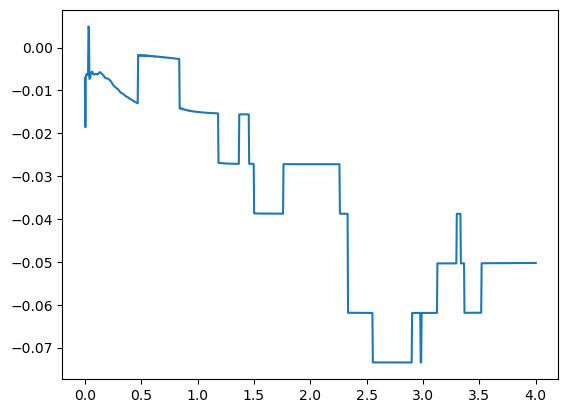

In [20]:
[plt.plot(ts[0]*1e3, v) for v in vx[:1]]

Text(0, 0.5, 'v [m/s]')

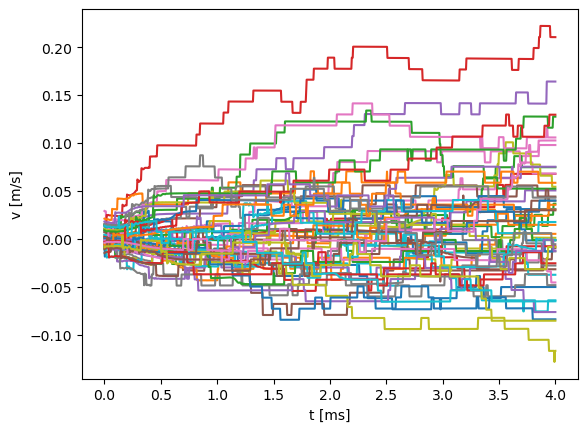

In [21]:
[plt.plot(ts[0]*1e3, v) for v in vx[:50]]
plt.xlabel("t [ms]")
plt.ylabel("v [m/s]")

Text(0, 0.5, 'Count')

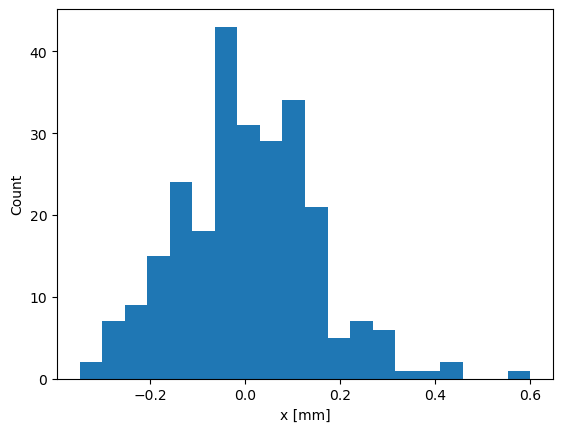

In [22]:
plt.hist(data['r'][:,0,-1]*mm_unit,bins=20)
plt.xlabel("x [mm]")
plt.ylabel("Count")